In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from init_objects import *
from hft_model import *
from functions.helpers import organise_data, prcnt_hft_trading, all_sharpe, sharpe

# Benchmark scenario
To start to get a feel for the model dynamics, I start with a simple benchmark scenario with a single HFM $N_{h} = 1$ and , where the fundamental is stationary $\sigma^f = 0$, and where there are no chartist LFTs $\sigma^{wc} = 0$.

In [2]:
NRUNS = 5

In [3]:
parameters = {
    # global parameters
    "n_lft": 100,
    "n_hft": 1,
    "ticks": 1000, # 390 ticks per day
    "ticks_per_minute": 1,
    "fundamental_value": 10,
    "std_fundamental": 0.0,
    "lft_sample_size": 0.05,
    "hft_sample_size": 1.0,
    "std_noise": 0.01,
    "std_LFT_vol": 4,
    "max_order_expiration_ticks": 30,
    "transaction_fee": 0.0,
    # lft parameters
    "w_fundamentalists": 1.0, #1
    "w_chartists": 0.0, # 10
    "w_random": 4.0,
    "spread_max": 0.004087, # from Riordann & Storkenmaier 2012
    # hft parameters
    "inventory_target": 1,
    "minimum_price_increment": 0.001,
    "hfm_risk_aversion": 25.0,
    # initial values
    "horizon_min": 1,
    "horizon_max": 9,
    "hfm_horizon_min": 1,
    "hfm_horizon_max": 5,
    "total_hft_money": 1000,
    "hft_speed": 1,
}

## 1 Baseline simulations

In [4]:
hfms = []
lfts = []
obs = []
for seed in range(NRUNS): # optional, remove tqdm(), it is used for the progress bar
    print('seed is ', seed)
    high_frequency_traders, low_frequency_traders, orderbook = init_objects(parameters)
    hft, lft, ob = hft_model(high_frequency_traders, low_frequency_traders, orderbook, parameters, seed)
    hfms.append(hft)
    lfts.append(lft)
    obs.append(ob)

seed is  0
tick:  250
tick:  500
tick:  750
seed is  1
tick:  250
tick:  500
tick:  750
seed is  2
tick:  250
tick:  500
tick:  750
seed is  3
tick:  250
tick:  500
tick:  750
seed is  4
tick:  250
tick:  500
tick:  750


C:\Users\p267237\Documents\GitHub\hfm-abm\hft_model.py:90: RuntimeWarning: divide by zero encountered in double_scalars
  stocks = np.divide(np.log(fcast_price / price), market_maker.par.risk_aversion * fcast_volatility * price)


In [5]:
mc_prices, mc_returns, mc_autocorr_returns, mc_autocorr_abs_returns, mc_volatility, mc_volume, mc_fundamentals = organise_data(obs)

### a Prices, Returns & Volume

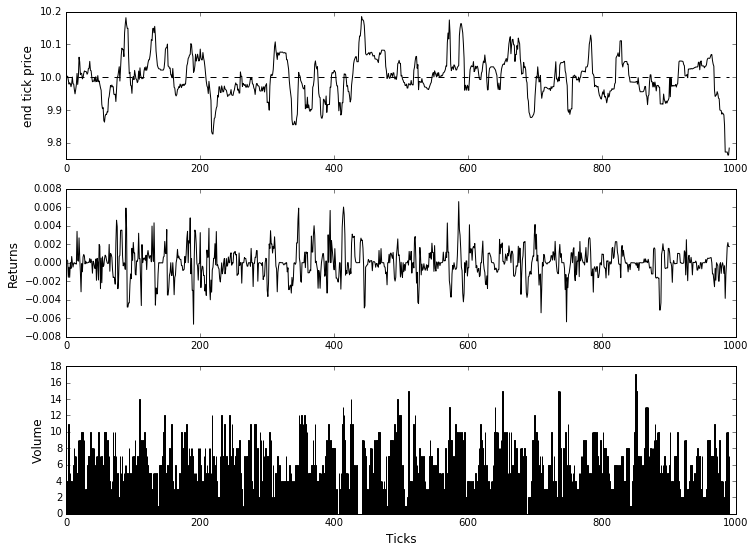

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,9))

ax1.plot(mc_fundamentals.index, mc_fundamentals.mean(axis=1), 'k--', label='fundamental value')
ax1.plot(mc_prices.index, mc_prices.median(axis=1), 'k-', label='close price')
ax1.set_ylabel('end tick price', fontsize='12')
#ax1.legend()

ax2.plot(mc_returns.index, mc_returns.median(axis=1), 'k-')
ax2.set_ylabel('Returns', fontsize='12')

ax3.bar(mc_volume.index, mc_volume.median(axis=1), color='k', edgecolor='k')
ax3.set_ylabel('Volume', fontsize='12')
ax3.set_xlabel('Ticks', fontsize='12')

#fig.savefig('benchmark_baseline_dynamics.png')

### b HFM profitability

In [7]:
percentage_trades_hfm = [prcnt_hft_trading(ob) for ob in obs]
percentage_trades_hfm

[0.004151404151404151,
 0.005124450951683748,
 0.003392294645020596,
 0.002185526954832443,
 0.0031568722680913063]

In [8]:
all_s = [all_sharpe(h) for h in hfms]
np.mean(all_s)

2.2219578566992881

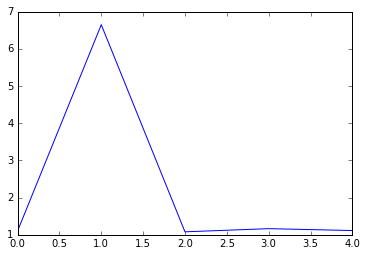

In [9]:
pd.Series(all_s).plot()

### c HFM quotes
Every tick, collect:
* bid-quote-price
* bid-quote-volume
* ask-quote-price
* ask-quote-volume

In [14]:
bid_quotes = [h[0].var_previous.bid_quote for h in hfms]
ask_quotes = [h[0].var_previous.ask_quote for h in hfms]
bid_volume = [h[0].var_previous.bid_quote_volume for h in hfms]
ask_volume = [h[0].var_previous.ask_quote_volume for h in hfms]

In [18]:
ask_volume

[[1, 5, 1, 1, 1, 1, 1, 1],
 [1, 1, 12, 1, 1, 1, 1, 1, 1, 1],
 [1, 1, 1, 1, 1, 1, 1, 1, 1],
 [1, 3, 3, 1, 1],
 [1, 1, 1, 1, 1, 1, 1]]

### d Autocorrelation of returns

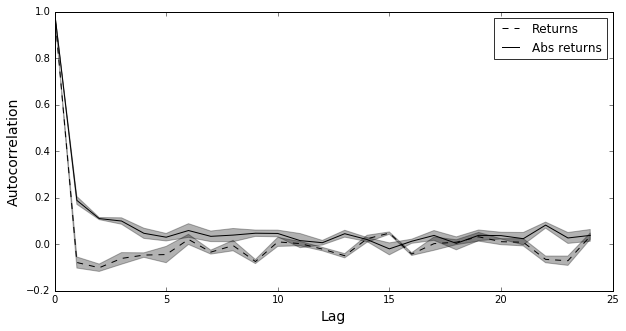

In [8]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

lenght = 20

ax1.plot(mc_autocorr_returns.index, mc_autocorr_returns.mean(axis=1), 'k--', label='Returns')
ax1.fill_between(mc_autocorr_returns.index, 
                 mc_autocorr_returns.mean(axis=1)+mc_autocorr_returns.std(axis=1), 
                 mc_autocorr_returns.mean(axis=1)-mc_autocorr_returns.std(axis=1), 
                 alpha=0.3, facecolor='black')

ax1.plot(mc_autocorr_abs_returns.index, mc_autocorr_abs_returns.mean(axis=1), 'k-', label='Abs returns')
ax1.fill_between(mc_autocorr_abs_returns.index, 
                 mc_autocorr_abs_returns.mean(axis=1)+mc_autocorr_abs_returns.std(axis=1), 
                 mc_autocorr_abs_returns.mean(axis=1)-mc_autocorr_abs_returns.std(axis=1), 
                 alpha=0.3, facecolor='black')

ax1.legend(frameon=True, loc='best', framealpha=0.8)
ax1.set_ylabel('Autocorrelation', fontsize='14')
ax1.set_xlabel('Lag', fontsize='14')

#fig.savefig('benchmark_autocorrelation.png')

## 2 Experiment no HFM vs HFM
Impact on: 
* spreads
* orderbook depth around the mid point.
* orderbook balance (increase)

## 3 Experiment increase HFM speed
Impact on:
* HFM profits 
* spreads? 